In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from shapely import wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import netCDF4
import xarray as xr
import dask
from scipy import stats

/Users/etriesch/.pyenv/versions/venv.ocean-carbon-sampling/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [76]:
plt.rcParams.update({'font.size': 18})
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
repo_path = Path('/Users/etriesch/dev/ocean-carbon-sampling/')
data_raw_path = repo_path / 'data/raw/'
data_clean_path = repo_path / 'data/clean/'
geo_crs = 'epsg:4326'
proj_crs = '+proj=cea'
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 400)

In [3]:
YEAR_LOOKBACK_MIN = 2016
YEAR_LOOKBACK_MAX = 2021

In [4]:
# Northeast Pacific mask
p_min_lat, p_max_lat = 29, 48
p_min_lon, p_max_lon = -140, -116
p_min_y, p_max_y = 996, 1460
p_min_x, p_max_x = 940, 1832
#Northwest Atlantic mask
a_min_lat, a_max_lat = 20, 48
a_min_lon, a_max_lon = -97, -60
a_min_y, a_max_y = 996, 1675
a_min_x, a_max_x = 1960, 2884

# Read and clean mooring data

In [5]:
moorings_folder = 'pco2_moorings'
m_files = [f for f in os.listdir(data_raw_path / moorings_folder) 
           if f.endswith('.csv')]
m_files.sort()

In [6]:
# read in mooring data
m = pd.DataFrame()
for f in m_files:
    skip=4
    d = pd.read_csv(data_raw_path / moorings_folder / f, skiprows=skip)
    while (d.columns[0] not in ['Mooring', 'Mooring Name']) & (skip >= 0):
        d = pd.read_csv(data_raw_path / moorings_folder / f, skiprows=skip)
        skip -= 1
    # clean up columns
    d.columns = d.columns.str.lower()
    d.columns = d.columns.str.replace('[()%]','',regex=True)
    d.columns = d.columns.str.replace('  ', ' ').str.replace(' ','_')
    d.columns = d.columns.str.replace(r'_c$', '',regex=True).str.replace(r'_uatm$', '',regex=True)
    d.columns = d.columns.str.replace(r'_umol/mol$', '',regex=True).str.replace(r'_mmol/mol$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ntu$', '',regex=True).str.replace(r'_hpa$', '',regex=True)
    d.columns = d.columns.str.replace(r'_ug/l$', '',regex=True).str.replace(r'umol/kg$', '',regex=True)
    m = pd.concat([m, d], axis=0)

In [43]:
# Clean dataset
# drop unnamed variables
m = m.loc[:, ~m.columns.str.startswith('unnamed')]

# clean up mooring names
m.loc[m['mooring_name'].isna(), 'mooring_name'] = m.loc[m['mooring_name'].isna(), 'mooring']
m.loc[m['mooring_name'].isin(['MS_89W_30N', 'CoastalMS', 'COASTALMS_88W_30N', 'COASTALMS_89W_30N']), 'mooring_name'] = 'COASTALMS_89W_30N'
m.loc[m['mooring_name'].isin(['GRAYSRF_81W_31N','GraysReef','GraysRf_81W_31N', 'GraysReef_81W_31N']), 'mooring_name'] = 'GRAYSRF_81W_31N'
# drop all other rows with missing mooring names (it's missing in all columns)
m = m.loc[m.mooring_name.notna()]

# make new variables
m.loc[:,'date'] = pd.to_datetime(m['date'])
m.loc[:,'year'] = m.date.dt.year
m.loc[:, 'month'] = m.date.dt.month
m.loc[:, 'date'] = m.date.dt.date
m.loc[:, 'moye'] = (m['year'] + m['month'] / 100).astype(str).str.pad(7, 'right', '0')

# subset to variables/years of interest and clean those
params = ['xco2_sw_wet', 'xco2_sw_dry', 'fco2_sw_sat', 'pco2_sw_sat']
m[params] = m[params].apply(pd.to_numeric, errors='coerce')
m[params] = m[params].replace({-999:np.nan})

# subset years and moorings
m_sub = m.loc[(m.year >= YEAR_LOOKBACK_MIN) & (m.year <= YEAR_LOOKBACK_MAX)]
drop_moorings = ['GRAYSRF_81W_31N', 'COASTALMS_89W_30N']
m_sub = m_sub.loc[~m_sub.mooring_name.isin(drop_moorings)].reset_index(drop=True)

## Summarize variability of pCO2

In [91]:
# summarize by month
param = 'pco2_sw_sat'
# param = 'xco2_sw_dry'
m_summ = m_sub.groupby(['mooring_name', 'moye', 'year', 'month'])[param].describe().reset_index()
m_summ = m_summ.sort_values(['mooring_name','moye'])

In [92]:
# get max monthly std per mooring
summ_monthly_std = m_summ.groupby('mooring_name')['std'].agg(mean_monthly='mean', max_monthly='max')

In [93]:
# get max annual std per mooring
summ_annual_std = m_sub.groupby(['mooring_name', 'year'])[param].describe().reset_index()
summ_annual_std = summ_annual_std.groupby('mooring_name')['std'].agg(mean_annual='mean', max_annual='max')

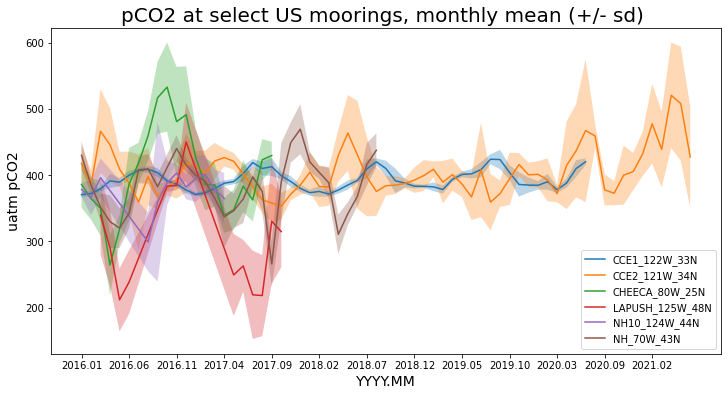

In [95]:
# plot
fit, ax = plt.subplots(figsize=(12,6))
plt.rcParams.update({'font.size': 10})

moorings = m_summ.mooring_name.drop_duplicates().values
for mo in moorings:
    temp = m_summ.loc[m_summ.mooring_name==mo]
    plt.plot(temp.moye, temp['mean'], label=mo)
#     plt.fill_between(temp.moye, temp['25%'], temp['75%'], alpha=0.3) #IQR
#     plt.fill_between(temp.moye, temp['min'], temp['max'], alpha=0.3) #Range
    plt.fill_between(temp.moye, temp['mean']-temp['std'], temp['mean']+temp['std'], alpha=0.3) #STD

axis_spacing = m_summ.moye.drop_duplicates().sort_values().to_list()[::5]
plt.xticks(axis_spacing)
plt.ylabel('uatm pCO2')
plt.xlabel('YYYY.MM')
plt.title('pCO2 at select US moorings, monthly mean (+/- sd) ')
plt.legend()
plt.show()

## Summarize variability in change in pCO2

In [83]:
# replace lat/lon with mean
m_sub['lat_cln'] = m_sub.groupby(['mooring_name'])['latitude'].transform('mean')
m_sub['lon_cln'] = m_sub.groupby(['mooring_name'])['longitude'].transform('mean')

In [84]:
# get daily average
m_d = m_sub.groupby(['mooring_name', 'lat_cln', 'lon_cln', 'date'])[param].agg(['mean', 'std']).reset_index()
old_dims = m_d.shape

In [85]:
# get all dates in period for each mooring
date_ranges = m_d.groupby(['mooring_name'])['date'].agg(['min','max'])
dates = pd.DataFrame()
for i in range(date_ranges.shape[0]):
    min_max = date_ranges.iloc[i]
    date = pd.DataFrame({'date': pd.date_range(min_max[0], min_max[1]-pd.to_timedelta(1), freq='d')})
    date['mooring_name'] = date_ranges.index[i]
    date['year'] = date.date.dt.year
    date['month'] = date.date.dt.month
    date['date'] = date.date.dt.date
    date['moye'] = (date['year'] + date['month'] / 100).astype(str).str.pad(7, 'right', '0')
    dates = date.append(dates)

In [86]:
# merge in these rows
m_d = pd.merge(left=m_d, right=dates, how='right', on=['mooring_name', 'date'])
m_d = m_d.sort_values(['mooring_name', 'date']).reset_index(drop=True)
print(f'interpolating {m_d.shape[0] - old_dims[0]} days out of {m_d.shape[0]}, ({(m_d.shape[0] - old_dims[0])/m_d.shape[0]})')

# nearest interpolation of points
m_d['mean'] = (
    m_d.groupby(['mooring_name', 'lat_cln', 'lon_cln', 'date', 'year', 'month', 'moye'])['mean']
    .apply(lambda group: group.interpolate(method='linear')))

interpolating 723 days out of 6243, (0.1158097068716963)


In [87]:
# get 30-day lag
m_d[['lag30', 'date_30lag']] = m_d.groupby('mooring_name')[['mean', 'date']].shift(30)
m_d['delta30'] = m_d['mean'] - m_d.lag30

# get 15-day lag
m_d[['lag15', 'date_15lag']] = m_d.groupby('mooring_name')[['mean', 'date']].shift(15)
m_d['delta15'] = m_d['mean'] - m_d.lag15

# get N-day difference std per mooring
summ_daydiff_std = m_d.groupby('mooring_name').agg(day_diff15=('delta15', 'std'), day_diff30=('delta30','std'))

In [88]:
# get monthly difference std per mooring
m_m = m_d.groupby(['mooring_name', 'year', 'month'])['mean'].describe().reset_index()
m_m['lag_month'] =  m_d.groupby('mooring_name')['mean'].shift(1)
m_m['delta_month'] = m_m['mean'] - m_m.lag_month
summ_monthlyavediff_summ = m_m.groupby(['mooring_name']).agg(mean_month_diff=('delta_month','std'))

## Summarize variability measures at key moorings

In [89]:
sds = pd.concat([summ_annual_std, summ_monthly_std, summ_daydiff_std, summ_monthlyavediff_summ], axis=1)

In [90]:
sds

,mean_annual,max_annual,mean_monthly,max_monthly,day_diff15,day_diff30,mean_month_diff
mooring_name,,,,,,,
CCE1_122W_33N,17.685591,19.445967,7.652304,19.369945,12.656755,15.331607,15.812418
CCE2_121W_34N,51.536359,77.199317,37.111190,102.335456,63.435234,63.782848,35.830260
CHEECA_80W_25N,73.292813,98.197138,43.200952,84.877357,70.339495,74.292196,68.575200
LAPUSH_125W_48N,84.406979,89.437868,51.713471,95.809636,88.612587,98.451278,78.997999
NH10_124W_44N,48.420383,60.495233,36.040249,120.526551,62.323878,65.314464,31.158289
NH_70W_43N,48.508249,52.515927,25.043113,60.650483,41.882619,55.060390,45.638432


[]

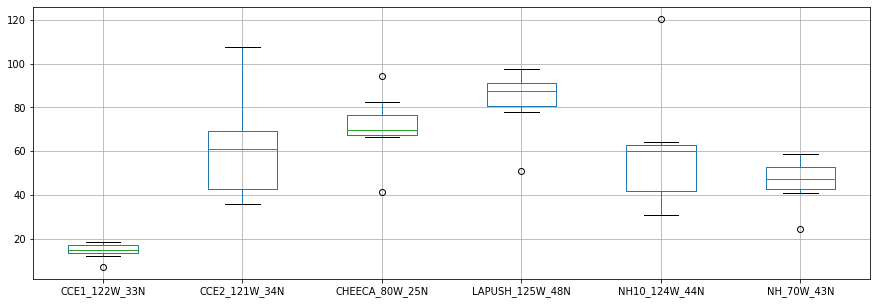

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
sds.T.boxplot()
plt.plot()

# Power calculation
Using normal distribution since sample size is large

$\begin{align*}
power &= 1 - cdf(zscore - delta/sigma * sqrt(n/2))\\
cdf(zscore - delta/sigma * sqrt(n/2)) &= (1 - power)\\
zscore - delta/sigma * sqrt(n/2) &= stats.norm.ppf(1 - power)\\
delta/sigma * sqrt(n/2) &= zscore - stats.norm.ppf(1 - power)\\
sqrt(n/2) &= (zscore - stats.norm.ppf(1 - power)) * sigma/delta\\
n &= 2*[(zscore - stats.norm.ppf(1 - power)) * sigma/delta]^2\\
\end{align*}$


In [99]:
# Zscore code
# zscore = stats.norm.ppf(1-alpha/2)
# 1 - stats.norm.cdf(zscore)
# stats.norm.cdf(-zscore)
# stats.norm.ppf(stats.norm.cdf(-zscore))

In [49]:
alpha = 0.05
power = 0.85
sigma = 48
delta = np.arange(10, 60, 1)

In [53]:
def get_sample_size(sigma, delta, alpha=0.05, power=0.85):
    '''
    alpha : confidence level (assume two-sided)
    power : power level
    sigma : standard deviation of the 
    '''
    n = 2 * np.square((stats.norm.ppf(1-alpha/2) - stats.norm.ppf(1-power)) * sigma / delta)
    return n

n_mid = get_sample_size(60, delta)
n_low = get_sample_size(35, delta)
n_high = get_sample_size(85, delta)

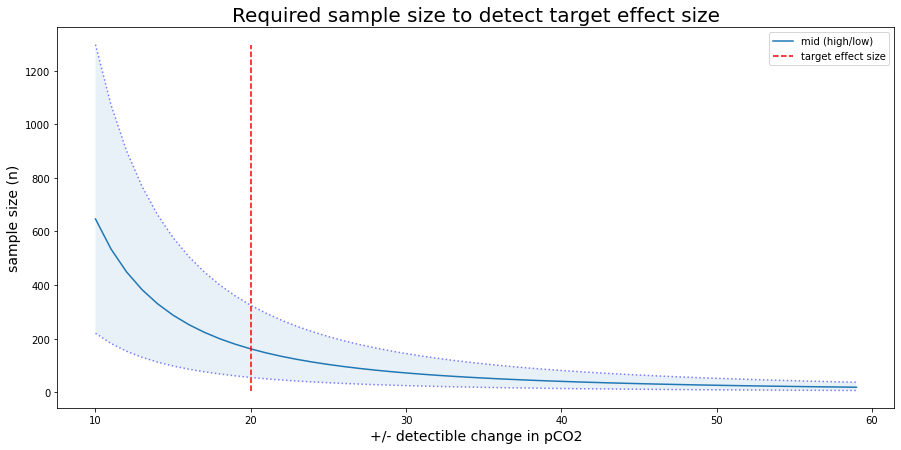

In [77]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot(delta, n_mid, label='mid (high/low)')
plt.plot(delta, n_low, linestyle=':', alpha=0.5, color='b')
plt.plot(delta, n_high, linestyle=':', alpha=0.5, color='b')
plt.fill_between(delta, n_low, n_high, alpha=0.1)
plt.vlines(x=20, ymin=n_low.min(), ymax=n_high.max(), color='r', linestyle='--', label='target effect size')
plt.legend()
plt.title('Required sample size to detect target effect size')
plt.ylabel('sample size (n)')
plt.xlabel('+/- detectible change in pCO2')
plt.show()

# Read and clean ship data (LDEO)

In [96]:
# Read in data
df = pd.read_csv(data_raw_path / 'LDEO_Database_V2019.csv', dtype={'FILENAME': str})

In [97]:
# Clean
df.columns = df.columns.str.lower()

# make date columns
df.loc[:,'date'] = pd.to_datetime(df['month/day/year'])
df.loc[:,'year'] = df.date.dt.year
df.loc[:,'month'] = df.date.dt.month

In [98]:
# subset to years of interest
df_sub = df.loc[(df.year >= YEAR_LOOKBACK_MIN) & (df.year <= YEAR_LOOKBACK_MAX)]

# Northeast Pacific subset
p_mask_lon = (df_sub.lon >= p_min_lon) & (df_sub.lon <= p_max_lon)
p_mask_lat = (df_sub.lat >= p_min_lat) & (df_sub.lat <= p_max_lat)
df_pac = df_sub[p_mask_lon & p_mask_lat]

#Northwest Atlantic subset
a_mask_lon = (df_sub.lon >= a_min_lon) & (df_sub.lon <= a_max_lon)
a_mask_lat = (df_sub.lat >= a_min_lat) & (df_sub.lat <= a_max_lat)
df_atl = df_sub[a_mask_lon & a_mask_lat]

df_sub = pd.concat([df_pac, df_atl]).reset_index(drop=True)

In [99]:
# turn into geodataframe
geometry = [Point(xy) for xy in zip(df_sub.lon, df_sub.lat)]
df_sub_geo = gpd.GeoDataFrame(df_sub, geometry=geometry, crs=proj_crs)

### Map onto xy coords for merging in analytical dataset

In [100]:
# read in lat/lon/xy from modis
c_files = [f for f in os.listdir(data_raw_path / 'color') if f.endswith('.nc')]
c = xr.open_dataset(data_raw_path / 'color' / c_files[0])

In [101]:
# create xy mappings
x = c.lon.to_dataframe().reset_index(drop=True).index
lon = c.coords['lon'].values
x_to_lon = pd.DataFrame({'x':x, 'lon':lon})

y = c.lat.to_dataframe().reset_index(drop=True).index
lat = c.coords['lat'].values
y_to_lat = pd.DataFrame({'y':y, 'lat':lat})

In [102]:
# map x/y to lon/lat
modis = c.chlor_a.to_dataframe().drop(columns='chlor_a').drop_duplicates().reset_index()
modis = pd.merge(left=modis, right=x_to_lon, how='inner', on='lon')
modis = pd.merge(left=modis, right=y_to_lat, how='inner', on='lat')

# subset to speed up computation
p_mask_lon = (modis.x >= p_min_x) & (modis.x <= p_max_x)
p_mask_lat = (modis.y >= p_min_y) & (modis.y <= p_max_y)
a_mask_lon = (modis.x >= a_min_x) & (modis.x <= a_max_x)
a_mask_lat = (modis.y >= a_min_y) & (modis.y <= a_max_y)
modis = modis.loc[(p_mask_lon & p_mask_lat) | (a_mask_lon & a_mask_lat)]

In [107]:
# make geodataframe
geometry = [Point(xy) for xy in zip(modis.lon, modis.lat)]
modis = gpd.GeoDataFrame(modis, geometry=geometry, crs=proj_crs)

In [116]:
# map LDEO data to x/y
print('Dataframe pre-merge:', df_sub_geo.shape)
df_geo = gpd.sjoin_nearest(left_df=df_sub_geo, right_df=modis, 
                           how='left', max_distance=0.25, distance_col='merge_dist')
print('Dataframe post-merge:', df_geo.shape)

Dataframe pre-merge: (920201, 19)
Dataframe post-merge: (923148, 25)


In [117]:
# bin by month and year
df_xy = df_geo.groupby(['x', 'y', 'month', 'year']).mean().reset_index()

In [120]:
# drop columns and rename others
df_xy = df_xy.drop(columns=['lat_left', 'lon_left', 'lat_right', 'lon_right', 'jdate', 'stn', 'index_right', 'merge_dist'])

## Write to file

In [122]:
filename = 'ship_pc02_monthly.csv.gz'
filepath = data_clean_path / filename
filepath.parent.mkdir(parents=True, exist_ok=True)

df_xy.to_csv(filepath, index=False, compression='gzip')

# Visualize

<AxesSubplot:>

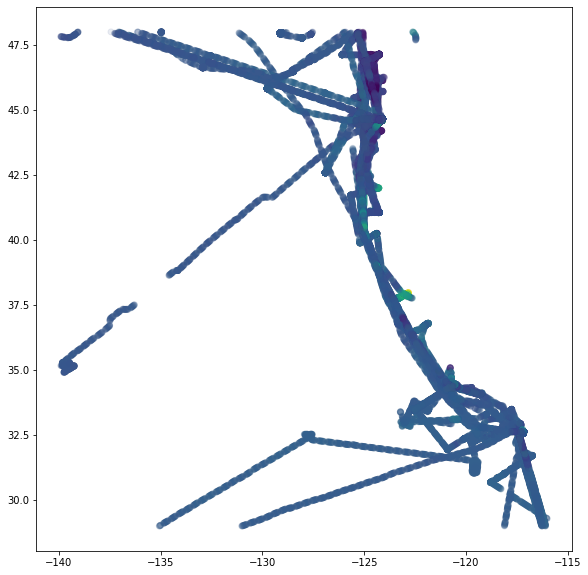

In [56]:
# ship data - pacific
geometry = [Point(xy) for xy in zip(df_pac['lon'], df_pac['lat'])]
geo_df_pac = gpd.GeoDataFrame(df_pac, crs=geo_crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_pac.plot(ax=ax, column='pco2_teq', alpha=0.1)

<AxesSubplot:>

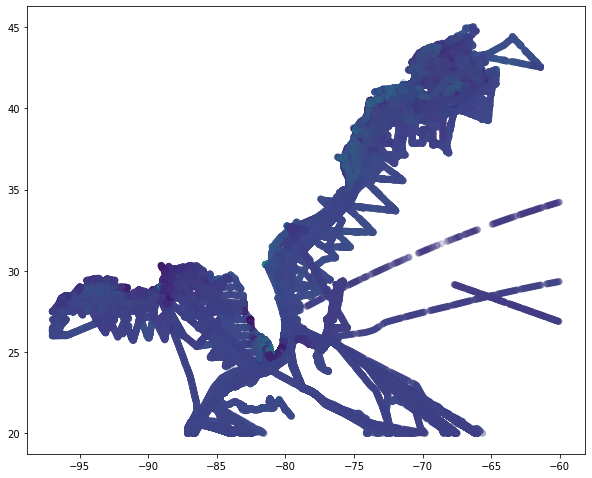

In [57]:
# ship data - atlantic
geometry = [Point(xy) for xy in zip(df_atl['lon'], df_atl['lat'])]
geo_df_atl = gpd.GeoDataFrame(df_atl, crs=geo_crs, geometry=geometry)
fig,ax = plt.subplots(figsize=(10,10))
geo_df_atl.plot(ax=ax, column='pco2_teq', alpha=0.1)